In [1]:
import math
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [2]:
print(tf.__version__)

2.10.0


In [3]:
table = pd.read_table('./1663769555_8559356_train.txt', names=['binding','sequence'])

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame, feat = None):
    if feat is None:
        count_vectorizer = CountVectorizer(binary=True)
    else:
        count_vectorizer = CountVectorizer(binary=True, vocabulary=feat)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [5]:
from sklearn.feature_selection import SelectKBest, chi2
def select_k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [6]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
# Mainly spliting the data here for testing, that is the reason train size is set to .20
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size= .80)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.90)

In [7]:
def createDf(data):
    pd_df = pd.DataFrame(data)
    return pd_df
def addColumn(copy_to, copy_from ,cname):
    copy_to[cname] = copy_from[cname]
    return copy_to

In [8]:
active_test_df = pd.DataFrame(active_test)
active_binding_test_df = pd.DataFrame(active_binding_test)
active_test_df['binding'] = active_binding_test_df['binding']
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)
not_active_test_df['binding'] = not_active_binding_test_df['binding']
active_train_df = createDf(active_train)
active_binding_train_df = createDf(active_binding_train)
active_train_df = addColumn(active_train_df, active_binding_train_df, 'binding')
not_active_train_df = createDf(not_active_train)
not_active_binding_train_df = createDf(not_active_binding_train)
not_active_train_df = addColumn(not_active_train_df, not_active_binding_train_df, 'binding')
train_df = pd.concat([active_train_df, not_active_train_df]).reset_index()
train_df = train_df.drop('index', axis=1)
print(train_df.binding.value_counts())
test_df = pd.concat([active_test_df, not_active_test_df]).reset_index()
test_df = test_df.drop('index', axis=1)
print(test_df.binding.value_counts())
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler()
x_sampled, y_sampled = sampler.fit_resample(np.array(train_df.sequence).reshape(-1, 1), train_df.binding)

0    649
1     62
Name: binding, dtype: int64
0    73
1    16
Name: binding, dtype: int64


In [9]:
final_train_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_train_set['binding'] = y_sampled
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(test_df.sequence, columns  =["sequence"])
final_test_set['binding'] = test_df.binding
print(final_test_set.binding.value_counts())

1    649
0    649
Name: binding, dtype: int64
0    73
1    16
Name: binding, dtype: int64


In [10]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)

In [11]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence)
test_split = vectorizer_best.transform(final_test_set.sequence).toarray()

In [12]:
print(training_split.shape)
print(test_split.shape)

(1298, 82818)
(89, 82818)


In [13]:
initial_weight = np.ones(training_split.shape[0])*(1/training_split.shape[0])

In [14]:
def updateWeight(missmatch, weight, alpha):
    mi = 0
    missmatch_size = len(missmatch)
    wi = 0

    new_weight = []
    norm_constant = 0
    while wi < len(weight):
        if mi < missmatch_size and missmatch[mi] == wi:
            k = weight[wi] * math.exp(alpha)
            mi+=1
        else:
            k = weight[wi] * math.exp(-1*alpha)
        new_weight.append( k )
        norm_constant += k
        wi += 1

    new_weight /= norm_constant
    sum =0
    for i in new_weight:
        sum+=i
    print(sum)
    # plt.plot(new_weight)
    # plt.show()
    return new_weight

In [15]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
def findMissClassificatonIndex(predicted, test_res, weight):
    error_rate = 0
    missmatch_indexes = []
    incorrect= []
    tn, fp, fn, tp = confusion_matrix(test_res, predicted).ravel()
    precision = tp / (tp+ fp)
    recall = tp / (tp+ fn)
    score = (2 * precision * recall) / (precision + recall)
    print(score)
    print(accuracy_score(test_res, predicted))
    for i, (pred, real) in enumerate(zip(predicted, test_res)):
        if pred != real:
            incorrect.append((i, pred, real))
            missmatch_indexes.append(i)
            error_rate += weight[i]
    error_rate /= len(predicted)
    # print(incorrect)
    return error_rate, missmatch_indexes

In [16]:
def rejectionSampling(train_data, train_res, weights):
    samplesize  = int(3 * len(train_data))
    new_train_data = []
    new_train_res = []
    new_weights = []
    adding_index =[]
    max_w = max(weights)

    for i in range(samplesize):
        while True:
            index = random.randrange(len(weights))
            u = max_w * random.random()
            if u <= weights[index]:
                new_train_data.append(train_data[index])
                new_train_res.append(train_res[index])
                adding_index.append(index)
                break
    # print(adding_index)
    return np.array(new_train_data), np.array(new_train_res)

In [56]:
def resample(train_data, train_res, weights):
    size = len(train_data)
    indexes = np.random.choice(int(size), int( .6 * size), replace=True, p=weights)
    new_train_data = []
    new_train_res = []
    for index in indexes:
         new_train_data.append(train_data[index])
         new_train_res.append(train_res[index])
    return np.array(new_train_data), np.array(new_train_res)

In [57]:
class EarlyStoppingMonitor(tf.keras.callbacks.Callback):
    def __init__(self):
        super(EarlyStoppingMonitor, self).__init__()
        self.f1_train = None
        self.f1_test = None
        self.count =0

    def on_epoch_end(self, epoch, logs=None):
        current_train_precision = logs.get('precision')
        current_train_recall= logs.get('recall')
        if current_train_precision==0 or current_train_recall==0:
            print("**** Waring: precision recall zero avoid exception ****")
            return
        self.f1_train = (2*current_train_precision*current_train_recall) / (current_train_precision+current_train_recall)
        if abs(self.f1_train) > .90:
            # self.count += 1
            # if self.count >4:
            self.model.stop_training = True
            print('\n\n******* Stoping on Defined Thresold *******')
            print('F1 TRAINING: ', self.f1_train)

    def on_train_end(self, logs=None):
        if self.model.stop_training:
            print("\n\n\n****** Early Stopping *******")

In [58]:
def createBaseModel():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(training_split.shape[-1],)),
        tf.keras.layers.Dense(2,activation='relu',kernel_regularizer=tf.keras.regularizers.L1(.015)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(), metrics=METRICS, optimizer='adam')

    return model

In [61]:
ensemble_size = 12
ensemble = []
alphas = []
def boosting(weights):

    for i in range(ensemble_size):
        train_data, train_res = resample(training_split, train_result, weights)
        model = createBaseModel()
        num_epochs = 50
        print( "bfore traning: ", ((sum(train_res)/len(train_res)))*100)
        model.fit(train_data, train_res,
                    epochs= num_epochs,
                    batch_size=70,
                    callbacks=[EarlyStoppingMonitor()])
        predicted_result = model.predict(training_split)
        predicted_result = [1 if i>=.5 else 0 for i in predicted_result ]
        error_rate, error_indexes = findMissClassificatonIndex(predicted_result, train_result, weights)
        print("error_rate:", error_rate)

        if error_rate > .5:
            weights = np.ones(training_split.shape[0]) * (1/training_split.shape[0])
            print("re-balancing and training because error:", error_rate)
            continue

        amount_of_say = 0.2 * ( math.log( (1-error_rate) / error_rate ) )
        alphas.append(amount_of_say)
        ensemble.append(model)
        weights = updateWeight(error_indexes, weights, amount_of_say)


In [62]:
# plt.plot(initial_weight)
boosting(initial_weight)

bfore traning:  45.62982005141388
Epoch 1/80


2022-11-09 23:57:36.466632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 77ms/step - loss: 4.4339 - tp: 141.0000 - fp: 59.0000 - tn: 364.0000 - fn: 214.0000 - precision: 0.7050 - recall: 0.3972
Epoch 2/80
12/12 [==============================] - 0s 30ms/step - loss: 1.5170 - tp: 81.0000 - fp: 3.0000 - tn: 420.0000 - fn: 274.0000 - precision: 0.9643 - recall: 0.2282
Epoch 3/80
12/12 [==============================] - 0s 27ms/step - loss: 0.8411 - tp: 172.0000 - fp: 1.0000 - tn: 422.0000 - fn: 183.0000 - precision: 0.9942 - recall: 0.4845
Epoch 4/80
12/12 [==============================] - 0s 20ms/step - loss: 0.6175 - tp: 116.0000 - fp: 0.0000e+00 - tn: 423.0000 - fn: 239.0000 - precision: 1.0000 - recall: 0.3268
Epoch 5/80
12/12 [==============================] - 0s 23ms/step - loss: 0.5440 - tp: 120.0000 - fp: 0.0000e+00 - tn: 423.0000 - fn: 235.0000 - precision: 1.0000 - recall: 0.3380
Epoch 6/80
12/12 [==============================] - 0s 22ms/step - loss: 0.5197 - tp: 74.0000 - fp: 1.0000 - tn: 422.0000 - fn: 

2022-11-09 23:57:57.913798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 7ms/step
0.9119341563786009
0.9175654853620955
error_rate: 6.35088710615597e-05
1.0000000000000058
bfore traning:  74.80719794344472
Epoch 1/80


2022-11-09 23:57:58.925220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 70ms/step - loss: 4.5446 - tp: 509.0000 - fp: 123.0000 - tn: 73.0000 - fn: 73.0000 - precision: 0.8054 - recall: 0.8746
Epoch 2/80
12/12 [==============================] - 0s 29ms/step - loss: 1.5548 - tp: 478.0000 - fp: 42.0000 - tn: 154.0000 - fn: 104.0000 - precision: 0.9192 - recall: 0.8213
Epoch 3/80
12/12 [==============================] - 0s 28ms/step - loss: 0.8721 - tp: 548.0000 - fp: 142.0000 - tn: 54.0000 - fn: 34.0000 - precision: 0.7942 - recall: 0.9416
Epoch 4/80
12/12 [==============================] - 0s 27ms/step - loss: 0.6270 - tp: 567.0000 - fp: 190.0000 - tn: 6.0000 - fn: 15.0000 - precision: 0.7490 - recall: 0.9742
Epoch 5/80
12/12 [==============================] - 0s 21ms/step - loss: 0.5367 - tp: 564.0000 - fp: 196.0000 - tn: 0.0000e+00 - fn: 18.0000 - precision: 0.7421 - recall: 0.9691
Epoch 6/80
12/12 [==============================] - 0s 20ms/step - loss: 0.5010 - tp: 565.0000 - fp: 196.0000 - tn: 0.0000e+00 - fn: 

2022-11-09 23:58:20.456584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 7ms/step
0.6666666666666666
0.5
error_rate: 0.00021014827570816106
1.0000000000000344
bfore traning:  17.480719794344473
Epoch 1/80


2022-11-09 23:58:21.452723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 75ms/step - loss: 4.4155 - tp: 15.0000 - fp: 32.0000 - tn: 610.0000 - fn: 121.0000 - precision: 0.3191 - recall: 0.1103
Epoch 2/80
12/12 [==============================] - 0s 25ms/step - loss: 1.5019 - tp: 21.0000 - fp: 0.0000e+00 - tn: 642.0000 - fn: 115.0000 - precision: 1.0000 - recall: 0.1544
Epoch 3/80
12/12 [==============================] - 0s 24ms/step - loss: 0.8223 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 642.0000 - fn: 136.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/80
12/12 [==============================] - 0s 25ms/step - loss: 0.5982 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 642.0000 - fn: 136.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/80
12/12 [==============================] - 0s 24ms/step - loss: 0.5217 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 642.0000 - fn: 136.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/80
12/12 [==============================] - 0s 23ms/step - loss: 0.4898 - tp: 0.000

2022-11-09 23:58:42.253091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 8ms/step
0.20221606648199444
0.5562403697996918
error_rate: 9.12470883735158e-05
0.999999999999972
bfore traning:  72.87917737789203
Epoch 1/80


2022-11-09 23:58:43.227476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 69ms/step - loss: 4.4166 - tp: 518.0000 - fp: 182.0000 - tn: 29.0000 - fn: 49.0000 - precision: 0.7400 - recall: 0.9136
Epoch 2/80
12/12 [==============================] - 0s 26ms/step - loss: 1.4945 - tp: 567.0000 - fp: 177.0000 - tn: 34.0000 - fn: 0.0000e+00 - precision: 0.7621 - recall: 1.0000
Epoch 3/80
12/12 [==============================] - 0s 22ms/step - loss: 0.8210 - tp: 567.0000 - fp: 210.0000 - tn: 1.0000 - fn: 0.0000e+00 - precision: 0.7297 - recall: 1.0000
Epoch 4/80
12/12 [==============================] - 0s 20ms/step - loss: 0.5991 - tp: 567.0000 - fp: 201.0000 - tn: 10.0000 - fn: 0.0000e+00 - precision: 0.7383 - recall: 1.0000
Epoch 5/80
12/12 [==============================] - 0s 22ms/step - loss: 0.5193 - tp: 567.0000 - fp: 208.0000 - tn: 3.0000 - fn: 0.0000e+00 - precision: 0.7316 - recall: 1.0000
Epoch 6/80
12/12 [==============================] - 0s 21ms/step - loss: 0.4951 - tp: 567.0000 - fp: 209.0000 - tn: 2.0000 - f

2022-11-09 23:59:03.893266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 8ms/step
0.813712807244502
0.7781201848998459
error_rate: 9.246894909184697e-05
0.9999999999999556
bfore traning:  28.92030848329049
Epoch 1/80


2022-11-09 23:59:04.886579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 74ms/step - loss: 4.4339 - tp: 63.0000 - fp: 25.0000 - tn: 528.0000 - fn: 162.0000 - precision: 0.7159 - recall: 0.2800
Epoch 2/80
12/12 [==============================] - 0s 28ms/step - loss: 1.5151 - tp: 181.0000 - fp: 0.0000e+00 - tn: 553.0000 - fn: 44.0000 - precision: 1.0000 - recall: 0.8044
Epoch 3/80
12/12 [==============================] - 0s 22ms/step - loss: 0.8698 - tp: 179.0000 - fp: 4.0000 - tn: 549.0000 - fn: 46.0000 - precision: 0.9781 - recall: 0.7956
Epoch 4/80
12/12 [==============================] - 0s 25ms/step - loss: 0.6318 - tp: 158.0000 - fp: 1.0000 - tn: 552.0000 - fn: 67.0000 - precision: 0.9937 - recall: 0.7022
Epoch 5/80
12/12 [==============================] - 0s 22ms/step - loss: 0.5587 - tp: 154.0000 - fp: 0.0000e+00 - tn: 553.0000 - fn: 71.0000 - precision: 1.0000 - recall: 0.6844
Epoch 6/80
12/12 [==============================] - 0s 23ms/step - loss: 0.5303 - tp: 152.0000 - fp: 1.0000 - tn: 552.0000 - fn: 73.

2022-11-09 23:59:25.767192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 7ms/step
0.6528497409326425
0.7419106317411402
error_rate: 5.127161620837811e-05
0.9999999999999897
bfore traning:  65.29562982005142
Epoch 1/80


2022-11-09 23:59:26.747318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 73ms/step - loss: 4.4378 - tp: 420.0000 - fp: 223.0000 - tn: 47.0000 - fn: 88.0000 - precision: 0.6532 - recall: 0.8268
Epoch 2/80
12/12 [==============================] - 0s 24ms/step - loss: 1.5100 - tp: 508.0000 - fp: 196.0000 - tn: 74.0000 - fn: 0.0000e+00 - precision: 0.7216 - recall: 1.0000
Epoch 3/80
12/12 [==============================] - 0s 32ms/step - loss: 0.8297 - tp: 506.0000 - fp: 260.0000 - tn: 10.0000 - fn: 2.0000 - precision: 0.6606 - recall: 0.9961
Epoch 4/80
12/12 [==============================] - 0s 23ms/step - loss: 0.6065 - tp: 508.0000 - fp: 263.0000 - tn: 7.0000 - fn: 0.0000e+00 - precision: 0.6589 - recall: 1.0000
Epoch 5/80
12/12 [==============================] - 0s 23ms/step - loss: 0.5334 - tp: 508.0000 - fp: 270.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.6530 - recall: 1.0000
Epoch 6/80
12/12 [==============================] - 0s 21ms/step - loss: 0.5061 - tp: 508.0000 - fp: 268.0000 - tn: 2.0000 - f

2022-11-09 23:59:43.663937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 7ms/step
0.865317515701326
0.8513097072419107
error_rate: 9.609151914597111e-05
0.9999999999999931
bfore traning:  34.318766066838045
Epoch 1/80


2022-11-09 23:59:45.929500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 3s 75ms/step - loss: 4.4363 - tp: 158.0000 - fp: 71.0000 - tn: 440.0000 - fn: 109.0000 - precision: 0.6900 - recall: 0.5918
Epoch 2/80
12/12 [==============================] - 0s 22ms/step - loss: 1.5164 - tp: 236.0000 - fp: 2.0000 - tn: 509.0000 - fn: 31.0000 - precision: 0.9916 - recall: 0.8839
Epoch 3/80
12/12 [==============================] - 0s 20ms/step - loss: 0.8363 - tp: 148.0000 - fp: 7.0000 - tn: 504.0000 - fn: 119.0000 - precision: 0.9548 - recall: 0.5543
Epoch 4/80
12/12 [==============================] - 0s 16ms/step - loss: 0.6078 - tp: 150.0000 - fp: 0.0000e+00 - tn: 511.0000 - fn: 117.0000 - precision: 1.0000 - recall: 0.5618
Epoch 5/80
12/12 [==============================] - 0s 17ms/step - loss: 0.5344 - tp: 123.0000 - fp: 0.0000e+00 - tn: 511.0000 - fn: 144.0000 - precision: 1.0000 - recall: 0.4607
Epoch 6/80
12/12 [==============================] - 0s 19ms/step - loss: 0.5053 - tp: 128.0000 - fp: 0.0000e+00 - tn: 511.0000 -

2022-11-10 00:00:03.550069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 5ms/step
0.5478841870824054
0.687211093990755
error_rate: 9.089319646402125e-05
0.9999999999999923
bfore traning:  68.76606683804627
Epoch 1/80


2022-11-10 00:00:04.453190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 73ms/step - loss: 4.4326 - tp: 522.0000 - fp: 238.0000 - tn: 5.0000 - fn: 13.0000 - precision: 0.6868 - recall: 0.9757
Epoch 2/80
12/12 [==============================] - 0s 22ms/step - loss: 1.4992 - tp: 535.0000 - fp: 243.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.6877 - recall: 1.0000
Epoch 3/80
12/12 [==============================] - 0s 22ms/step - loss: 0.8262 - tp: 535.0000 - fp: 243.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.6877 - recall: 1.0000
Epoch 4/80
12/12 [==============================] - 0s 19ms/step - loss: 0.6065 - tp: 535.0000 - fp: 243.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.6877 - recall: 1.0000
Epoch 5/80
12/12 [==============================] - 0s 18ms/step - loss: 0.5236 - tp: 535.0000 - fp: 243.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.6877 - recall: 1.0000
Epoch 6/80
12/12 [==============================] - 0s 19ms/step - loss: 0.5012 - tp: 535.0000 - fp: 243.0000 - t

2022-11-10 00:00:18.112053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 6ms/step
0.7186098654708521
0.613251155624037
error_rate: 9.010051381616231e-05
0.999999999999983
bfore traning:  26.606683804627252
Epoch 1/80


2022-11-10 00:00:19.072449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 80ms/step - loss: 4.4144 - tp: 35.0000 - fp: 53.0000 - tn: 518.0000 - fn: 172.0000 - precision: 0.3977 - recall: 0.1691
Epoch 2/80
12/12 [==============================] - 0s 22ms/step - loss: 1.5071 - tp: 24.0000 - fp: 0.0000e+00 - tn: 571.0000 - fn: 183.0000 - precision: 1.0000 - recall: 0.1159
Epoch 3/80
12/12 [==============================] - 0s 23ms/step - loss: 0.8278 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 571.0000 - fn: 207.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/80
12/12 [==============================] - 0s 23ms/step - loss: 0.6066 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 571.0000 - fn: 207.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/80
12/12 [==============================] - 0s 22ms/step - loss: 0.5286 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 571.0000 - fn: 207.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/80
12/12 [==============================] - 0s 17ms/step - loss: 0.5018 - tp: 0.000

2022-11-10 00:00:36.914892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 6ms/step
0.4054054054054054
0.6271186440677966
error_rate: 9.549610299195768e-05
0.9999999999999953
bfore traning:  74.42159383033419
Epoch 1/80


2022-11-10 00:00:37.852164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 78ms/step - loss: 4.4106 - tp: 540.0000 - fp: 180.0000 - tn: 19.0000 - fn: 39.0000 - precision: 0.7500 - recall: 0.9326
Epoch 2/80
12/12 [==============================] - 0s 19ms/step - loss: 1.4936 - tp: 579.0000 - fp: 199.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.7442 - recall: 1.0000
Epoch 3/80
12/12 [==============================] - 0s 22ms/step - loss: 0.8146 - tp: 579.0000 - fp: 199.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.7442 - recall: 1.0000
Epoch 4/80
12/12 [==============================] - 0s 18ms/step - loss: 0.5981 - tp: 579.0000 - fp: 199.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.7442 - recall: 1.0000
Epoch 5/80
12/12 [==============================] - 0s 22ms/step - loss: 0.5178 - tp: 579.0000 - fp: 199.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.7442 - recall: 1.0000
Epoch 6/80
12/12 [==============================] - 0s 20ms/step - loss: 0.4907 - tp: 579.0000 - fp: 199.0000 - 

2022-11-10 00:00:57.093523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 7ms/step
0.7792536369386465
0.7311248073959938
error_rate: 0.00010650630514518314
0.9999999999999865
bfore traning:  31.619537275064268
Epoch 1/80


2022-11-10 00:00:58.217582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 81ms/step - loss: 4.4411 - tp: 137.0000 - fp: 46.0000 - tn: 486.0000 - fn: 109.0000 - precision: 0.7486 - recall: 0.5569
Epoch 2/80
12/12 [==============================] - 0s 22ms/step - loss: 1.5156 - tp: 208.0000 - fp: 0.0000e+00 - tn: 532.0000 - fn: 38.0000 - precision: 1.0000 - recall: 0.8455
Epoch 3/80
12/12 [==============================] - 0s 28ms/step - loss: 0.8402 - tp: 76.0000 - fp: 0.0000e+00 - tn: 532.0000 - fn: 170.0000 - precision: 1.0000 - recall: 0.3089
Epoch 4/80
12/12 [==============================] - 0s 22ms/step - loss: 0.6161 - tp: 125.0000 - fp: 0.0000e+00 - tn: 532.0000 - fn: 121.0000 - precision: 1.0000 - recall: 0.5081
Epoch 5/80
12/12 [==============================] - 0s 20ms/step - loss: 0.5349 - tp: 114.0000 - fp: 0.0000e+00 - tn: 532.0000 - fn: 132.0000 - precision: 1.0000 - recall: 0.4634
Epoch 6/80
12/12 [==============================] - 0s 23ms/step - loss: 0.5224 - tp: 126.0000 - fp: 0.0000e+00 - tn: 532

2022-11-10 00:01:16.371682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 5ms/step
0.5
0.6656394453004623
error_rate: 5.685727539260967e-05
1.000000000000012
bfore traning:  66.45244215938303
Epoch 1/80


2022-11-10 00:01:17.333588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 77ms/step - loss: 4.4843 - tp: 504.0000 - fp: 232.0000 - tn: 29.0000 - fn: 13.0000 - precision: 0.6848 - recall: 0.9749
Epoch 2/80
12/12 [==============================] - 0s 23ms/step - loss: 1.5193 - tp: 516.0000 - fp: 132.0000 - tn: 129.0000 - fn: 1.0000 - precision: 0.7963 - recall: 0.9981
Epoch 3/80
12/12 [==============================] - 0s 20ms/step - loss: 0.8373 - tp: 517.0000 - fp: 160.0000 - tn: 101.0000 - fn: 0.0000e+00 - precision: 0.7637 - recall: 1.0000
Epoch 4/80
12/12 [==============================] - 0s 19ms/step - loss: 0.6264 - tp: 516.0000 - fp: 165.0000 - tn: 96.0000 - fn: 1.0000 - precision: 0.7577 - recall: 0.9981
Epoch 5/80
12/12 [==============================] - 0s 19ms/step - loss: 0.5368 - tp: 516.0000 - fp: 155.0000 - tn: 106.0000 - fn: 1.0000 - precision: 0.7690 - recall: 0.9981
Epoch 6/80
12/12 [==============================] - 0s 16ms/step - loss: 0.5123 - tp: 516.0000 - fp: 166.0000 - tn: 95.0000 - fn: 1.0

2022-11-10 00:01:25.834635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 6ms/step
0.8131443298969072
0.7765793528505393
error_rate: 7.801547328200643e-05
0.9999999999999931
bfore traning:  37.660668380462724
Epoch 1/80


2022-11-10 00:01:26.720608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 73ms/step - loss: 4.4250 - tp: 207.0000 - fp: 45.0000 - tn: 440.0000 - fn: 86.0000 - precision: 0.8214 - recall: 0.7065
Epoch 2/80
12/12 [==============================] - 0s 23ms/step - loss: 1.5087 - tp: 232.0000 - fp: 0.0000e+00 - tn: 485.0000 - fn: 61.0000 - precision: 1.0000 - recall: 0.7918
Epoch 3/80
12/12 [==============================] - 0s 20ms/step - loss: 0.8280 - tp: 190.0000 - fp: 1.0000 - tn: 484.0000 - fn: 103.0000 - precision: 0.9948 - recall: 0.6485
Epoch 4/80
12/12 [==============================] - 0s 20ms/step - loss: 0.6069 - tp: 184.0000 - fp: 0.0000e+00 - tn: 485.0000 - fn: 109.0000 - precision: 1.0000 - recall: 0.6280
Epoch 5/80
12/12 [==============================] - 0s 17ms/step - loss: 0.5342 - tp: 186.0000 - fp: 1.0000 - tn: 484.0000 - fn: 107.0000 - precision: 0.9947 - recall: 0.6348
Epoch 6/80
12/12 [==============================] - 0s 18ms/step - loss: 0.5079 - tp: 177.0000 - fp: 0.0000e+00 - tn: 485.0000 - 

2022-11-10 00:01:44.196759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 6ms/step
0.22888283378746593
0.5639445300462249
error_rate: 9.618478049545827e-05
1.0000000000000029
bfore traning:  75.83547557840618
Epoch 1/80


2022-11-10 00:01:45.167043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 75ms/step - loss: 4.4177 - tp: 530.0000 - fp: 138.0000 - tn: 50.0000 - fn: 60.0000 - precision: 0.7934 - recall: 0.8983
Epoch 2/80
12/12 [==============================] - 0s 23ms/step - loss: 1.5037 - tp: 590.0000 - fp: 109.0000 - tn: 79.0000 - fn: 0.0000e+00 - precision: 0.8441 - recall: 1.0000
Epoch 3/80
12/12 [==============================] - 0s 17ms/step - loss: 0.8267 - tp: 590.0000 - fp: 169.0000 - tn: 19.0000 - fn: 0.0000e+00 - precision: 0.7773 - recall: 1.0000
Epoch 4/80
12/12 [==============================] - 0s 19ms/step - loss: 0.6047 - tp: 590.0000 - fp: 175.0000 - tn: 13.0000 - fn: 0.0000e+00 - precision: 0.7712 - recall: 1.0000
Epoch 5/80
12/12 [==============================] - 0s 20ms/step - loss: 0.5277 - tp: 590.0000 - fp: 173.0000 - tn: 15.0000 - fn: 0.0000e+00 - precision: 0.7733 - recall: 1.0000
Epoch 6/80
12/12 [==============================] - 0s 19ms/step - loss: 0.5013 - tp: 590.0000 - fp: 188.0000 - tn: 0.0000e+

2022-11-10 00:02:02.680560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 6ms/step
0.6659674882013634
0.5092449922958397
error_rate: 9.337518828960853e-05
0.999999999999999
bfore traning:  27.37789203084833
Epoch 1/80


2022-11-10 00:02:03.562477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 70ms/step - loss: 4.4146 - tp: 46.0000 - fp: 63.0000 - tn: 502.0000 - fn: 167.0000 - precision: 0.4220 - recall: 0.2160
Epoch 2/80
12/12 [==============================] - 0s 25ms/step - loss: 1.5149 - tp: 16.0000 - fp: 0.0000e+00 - tn: 565.0000 - fn: 197.0000 - precision: 1.0000 - recall: 0.0751
Epoch 3/80
12/12 [==============================] - 0s 21ms/step - loss: 0.8385 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 565.0000 - fn: 213.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/80
12/12 [==============================] - 0s 22ms/step - loss: 0.6195 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 565.0000 - fn: 213.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/80
12/12 [==============================] - 0s 21ms/step - loss: 0.5411 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 565.0000 - fn: 213.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/80
12/12 [==============================] - 0s 18ms/step - loss: 0.5115 - tp: 0.000

2022-11-10 00:02:21.994819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 7ms/step
0.6960882647943832
0.7665639445300462
error_rate: 0.00011296020225765823
0.9999999999999959
bfore traning:  71.8508997429306
Epoch 1/80


2022-11-10 00:02:23.003456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 76ms/step - loss: 4.4145 - tp: 551.0000 - fp: 216.0000 - tn: 3.0000 - fn: 8.0000 - precision: 0.7184 - recall: 0.9857
Epoch 2/80
12/12 [==============================] - 0s 26ms/step - loss: 1.4973 - tp: 559.0000 - fp: 219.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.7185 - recall: 1.0000
Epoch 3/80
12/12 [==============================] - 0s 26ms/step - loss: 0.8236 - tp: 559.0000 - fp: 219.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.7185 - recall: 1.0000
Epoch 4/80
12/12 [==============================] - 0s 21ms/step - loss: 0.6100 - tp: 559.0000 - fp: 219.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.7185 - recall: 1.0000
Epoch 5/80
12/12 [==============================] - 0s 22ms/step - loss: 0.5277 - tp: 559.0000 - fp: 219.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.7185 - recall: 1.0000
Epoch 6/80
12/12 [==============================] - 0s 23ms/step - loss: 0.5024 - tp: 559.0000 - fp: 219.0000 - tn

2022-11-10 00:02:38.123975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 7ms/step
0.780298120544394
0.7388289676425269
error_rate: 7.812977052051314e-05
0.9999999999999879
bfore traning:  33.41902313624679
Epoch 1/80


2022-11-10 00:02:39.048952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 75ms/step - loss: 4.4363 - tp: 97.0000 - fp: 114.0000 - tn: 404.0000 - fn: 163.0000 - precision: 0.4597 - recall: 0.3731
Epoch 2/80
12/12 [==============================] - 0s 25ms/step - loss: 1.5061 - tp: 239.0000 - fp: 43.0000 - tn: 475.0000 - fn: 21.0000 - precision: 0.8475 - recall: 0.9192
Epoch 3/80
12/12 [==============================] - 0s 25ms/step - loss: 0.8315 - tp: 149.0000 - fp: 5.0000 - tn: 513.0000 - fn: 111.0000 - precision: 0.9675 - recall: 0.5731
Epoch 4/80
12/12 [==============================] - 0s 22ms/step - loss: 0.6131 - tp: 78.0000 - fp: 5.0000 - tn: 513.0000 - fn: 182.0000 - precision: 0.9398 - recall: 0.3000
Epoch 5/80
12/12 [==============================] - 0s 24ms/step - loss: 0.5363 - tp: 31.0000 - fp: 0.0000e+00 - tn: 518.0000 - fn: 229.0000 - precision: 1.0000 - recall: 0.1192
Epoch 6/80
12/12 [==============================] - 0s 22ms/step - loss: 0.5118 - tp: 3.0000 - fp: 0.0000e+00 - tn: 518.0000 - fn: 25

2022-11-10 00:03:00.020062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 8ms/step
0.6330178759200841
0.7311248073959938
error_rate: 3.823878101699589e-05
0.9999999999999974
bfore traning:  64.26735218508998
Epoch 1/80


2022-11-10 00:03:01.004386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 70ms/step - loss: 4.4443 - tp: 444.0000 - fp: 218.0000 - tn: 60.0000 - fn: 56.0000 - precision: 0.6707 - recall: 0.8880
Epoch 2/80
12/12 [==============================] - 0s 28ms/step - loss: 1.5090 - tp: 494.0000 - fp: 100.0000 - tn: 178.0000 - fn: 6.0000 - precision: 0.8316 - recall: 0.9880
Epoch 3/80
12/12 [==============================] - 0s 24ms/step - loss: 0.8343 - tp: 496.0000 - fp: 211.0000 - tn: 67.0000 - fn: 4.0000 - precision: 0.7016 - recall: 0.9920
Epoch 4/80
12/12 [==============================] - 0s 30ms/step - loss: 0.6085 - tp: 499.0000 - fp: 262.0000 - tn: 16.0000 - fn: 1.0000 - precision: 0.6557 - recall: 0.9980
Epoch 5/80
12/12 [==============================] - 0s 31ms/step - loss: 0.5300 - tp: 499.0000 - fp: 267.0000 - tn: 11.0000 - fn: 1.0000 - precision: 0.6514 - recall: 0.9980
Epoch 6/80
12/12 [==============================] - 0s 22ms/step - loss: 0.5062 - tp: 499.0000 - fp: 270.0000 - tn: 8.0000 - fn: 1.0000 - p

2022-11-10 00:03:22.241065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 8ms/step
0.944794952681388
0.9460708782742681
error_rate: 5.6637206569660906e-05
1.0000000000000038
bfore traning:  51.54241645244216
Epoch 1/80


2022-11-10 00:03:23.237074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 90ms/step - loss: 4.4495 - tp: 261.0000 - fp: 53.0000 - tn: 324.0000 - fn: 140.0000 - precision: 0.8312 - recall: 0.6509
Epoch 2/80
12/12 [==============================] - 0s 37ms/step - loss: 1.5112 - tp: 319.0000 - fp: 1.0000 - tn: 376.0000 - fn: 82.0000 - precision: 0.9969 - recall: 0.7955
Epoch 3/80
12/12 [==============================] - 0s 27ms/step - loss: 0.8294 - tp: 293.0000 - fp: 5.0000 - tn: 372.0000 - fn: 108.0000 - precision: 0.9832 - recall: 0.7307
Epoch 4/80
12/12 [==============================] - 0s 25ms/step - loss: 0.6111 - tp: 277.0000 - fp: 11.0000 - tn: 366.0000 - fn: 124.0000 - precision: 0.9618 - recall: 0.6908
Epoch 5/80
12/12 [==============================] - 0s 20ms/step - loss: 0.5351 - tp: 301.0000 - fp: 12.0000 - tn: 365.0000 - fn: 100.0000 - precision: 0.9617 - recall: 0.7506
Epoch 6/80
12/12 [==============================] - 0s 25ms/step - loss: 0.5022 - tp: 325.0000 - fp: 23.0000 - tn: 354.0000 - fn: 76.0

2022-11-10 00:03:44.600388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 8ms/step
0.7139364303178485
0.6394453004622496
error_rate: 5.752531171116827e-05
1.0000000000000007
bfore traning:  31.362467866323907
Epoch 1/80


2022-11-10 00:03:45.743974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 85ms/step - loss: 4.4284 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 534.0000 - fn: 244.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/80
12/12 [==============================] - 0s 23ms/step - loss: 1.5076 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 534.0000 - fn: 244.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/80
12/12 [==============================] - 0s 25ms/step - loss: 0.8297 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 534.0000 - fn: 244.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/80
12/12 [==============================] - 0s 22ms/step - loss: 0.6046 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 534.0000 - fn: 244.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/80
12/12 [==============================] - 0s 16ms/step - loss: 0.5273 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 534.0000 - fn: 244.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/80
12/12 [==============================] - 0s 17ms/step -

2022-11-10 00:04:03.451548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 6ms/step
0.27814569536423844
0.5801232665639445
error_rate: 8.318149843643228e-05
0.9999999999999989


In [63]:
alphas

[1.4496401173767492,
 1.2701230546859439,
 1.3952772334491828,
 1.3932817773104729,
 1.481748296439523,
 1.3875170100072227,
 1.395860176295231,
 1.3971741879091546,
 1.3884494425521139,
 1.3720799789023104,
 1.4662364267730357,
 1.4187788035532245,
 1.3873714845465024,
 1.3918187277715286,
 1.3632543040670413,
 1.418559188442987,
 1.5257433161921448,
 1.4668181685034483,
 1.4644841964575,
 1.4091603636704852]

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def repeat(test_split, test_result, start, end):
    mx = 0
    size = 0
    data = []
    f1=[]
    for i in range(start,end):
        data = some_pred(test_split, i)
        tn, fp, fn, tp = confusion_matrix(test_result, data).ravel()
        precision = tp / (tp+ fp)
        recall = tp / (tp+ fn)
        score = (2 * precision * recall) / (precision + recall)
        print(score)
        f1.append(score)
        if mx < score:
            mx = score
            size = i
        print(i)
    print(mx,size)
    return data, f1

# ensemble[0].predict()

def some_pred(test_split, esize):
    data = []
    for j in range(len(test_split)):
        pa=0
        na =0
        for i in range(esize):
            k = ensemble[i].predict([[test_split[j].reshape(1,-1)]])
            if k[0] >= .5:
                pa += alphas[i]
            else:
                na+=alphas[i]
        if pa >=na:
            data.append(1)
        else:
            data.append(0)
    # f1.append(f1_score(test_result, data, average="macro"))
    # acc.append(accuracy_score(test_result, data))
    return data

1/1 [==============================] - 0s 74ms/step


2022-11-10 00:05:39.168053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 00:05:39.265360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 00:05:39.355457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 67ms/step


2022-11-10 00:05:39.449615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 00:05:39.531325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 00:05:39.613857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 61ms/step


2022-11-10 00:05:39.702307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 00:05:39.784462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 00:05:39.860147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 66ms/step


2022-11-10 00:05:39.942635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 00:05:40.017452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 00:05:40.100224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 60ms/step


2022-11-10 00:05:40.174048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 00:05:40.263810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 00:05:40.337640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 60ms/step


2022-11-10 00:05:40.420088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 00:05:40.497024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 00:05:40.578955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 24ms/step


2022-11-10 00:05:40.657114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 00:05:40.744585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 9ms/step


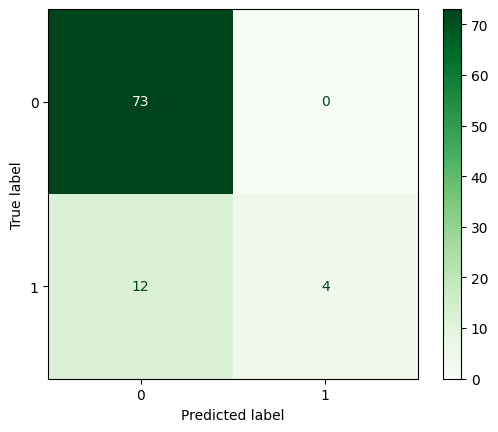

In [64]:
data, f1 = repeat(test_split, test_result, 0, 12)
ConfusionMatrixDisplay.from_predictions(test_result,data,cmap='Greens')

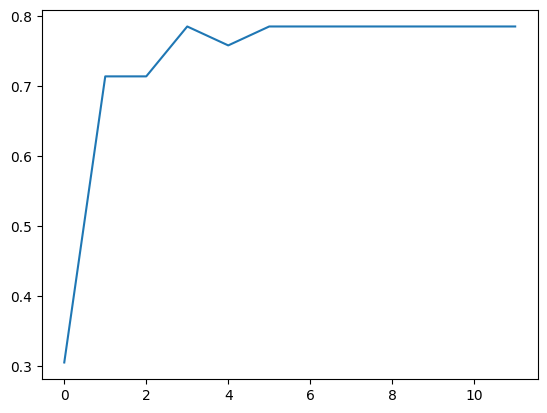

In [51]:
plt.plot(f1)

1/1 [==============================] - 0s 11ms/step


2022-11-09 23:41:17.458672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step


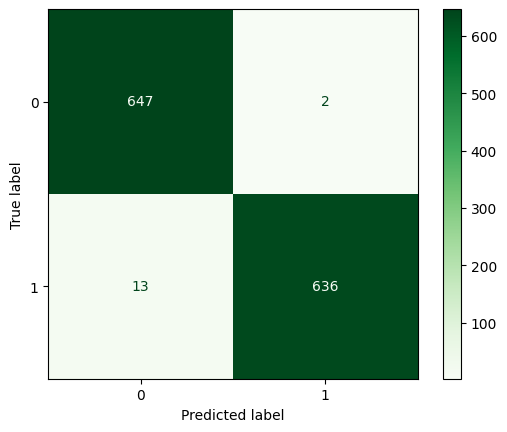

In [52]:
data =some_pred(training_split, 12)
ConfusionMatrixDisplay.from_predictions(train_result,data,cmap='Greens')


In [53]:
table_test = pd.read_table('./1663769555_8653905_test.txt', names=['sequence'])
unlabeled_test = vectorizer_best.transform(table_test.sequence).toarray()
predicted_data = some_pred(unlabeled_test, 12)

1/1 [==============================] - 0s 9ms/step


In [54]:
len(predicted_data)
predicted_data

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,


In [55]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], predicted_data))
outfile.close()